In [1]:
import pandas as pd
import dask.dataframe as dd
import dask
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from glob import glob
import os
import gc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import tqdm

gc.collect()

27

In [2]:
train_path = '/home/stargix/Desktop/hackathons/datathon/train/train'
test_path = '/home/stargix/Desktop/hackathons/datathon/test/test'

In [3]:
# Definir columnas necesarias
required_columns = [
    'row_id', 'datetime',
    'buyer_d7', 'iap_revenue_d7',
    'advertiser_bundle', 'advertiser_category', 'advertiser_subcategory', 
    'advertiser_bottom_taxonomy_level',
    'country', 'region',
    'dev_make', 'dev_model', 'dev_os', 'dev_osv',
    'carrier',
    'hour', 'weekday', 'weekend_ratio', 'hour_ratio',
    'release_date', 'release_msrp',
    'avg_act_days', 'avg_daily_sessions', 'avg_days_ins', 'avg_duration',
    'weeks_since_first_seen', 'wifi_ratio',
    'retentiond7',
    'city_hist', 'country_hist', 'region_hist', 'dev_language_hist', 'dev_osv_hist',
    'cpm', 'cpm_pct_rk', 'ctr', 'ctr_pct_rk',
    'iap_revenue_usd_bundle', 'iap_revenue_usd_category',
    'num_buys_bundle', 'num_buys_category',
    'last_buy', 'last_ins',
    'bcat', 'bcat_bottom_taxonomy',
    'bundles_cat', 'bundles_cat_bottom_taxonomy', 
    'bundles_ins',
    'new_bundles', 'user_bundles', 'user_bundles_l28d',
    'advertiser_actions_action_count', 'advertiser_actions_action_last_timestamp',
    'user_actions_bundles_action_count', 'user_actions_bundles_action_last_timestamp',
    'last_advertiser_action',
    'first_request_ts', 'first_request_ts_bundle', 
    'first_request_ts_category_bottom_taxonomy',
    'rwd_prank',
    'whale_users_bundle_num_buys_prank', 'whale_users_bundle_revenue_prank'
]

# Cargar datos (10% de los archivos)
parquet_files_train = glob(os.path.join(train_path, '**/part-*.parquet'), recursive=True)
num_files_train = max(1, int(len(parquet_files_train) * 0.1))
parquet_files_train = parquet_files_train[:num_files_train]

try:
    train_ddf = dd.read_parquet(parquet_files_train, engine='pyarrow', columns=required_columns)
    print(f"✓ Train cargado con {num_files_train} archivos")
except Exception as e:
    print(f"⚠️ Cargando todas las columnas: {e}")
    train_ddf = dd.read_parquet(parquet_files_train, engine='pyarrow')

# Computar a Pandas
train_df = train_ddf.compute(scheduler='synchronous')
print(f"✓ Train shape: {train_df.shape}")

✓ Train cargado con 14 archivos
✓ Train shape: (2104266, 62)
✓ Train shape: (2104266, 62)


In [4]:
# Preprocesar columnas con listas - SUMAR todos los valores
import ast

columns_to_sum = [
    'iap_revenue_usd_bundle',
    'num_buys_bundle',
    'rwd_prank',
    'whale_users_bundle_num_buys_prank',
    'whale_users_bundle_revenue_prank'
]

print("=" * 60)
print("PREPROCESANDO COLUMNAS CON LISTAS")
print("=" * 60)

def sum_values(x):
    """Suma todos los valores numéricos de la lista"""
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return 0
    try:
        # Si es string, convertir a lista
        if isinstance(x, str):
            x = ast.literal_eval(x)
        
        # Si es lista de tuplas, sumar el segundo valor de cada tupla
        if isinstance(x, list) and len(x) > 0:
            total = sum([item[1] for item in x if isinstance(item, tuple) and len(item) > 1])
            return total
        return 0
    except:
        return 0

for col in columns_to_sum:
    if col in train_df.columns:
        print(f"\n📊 Procesando {col}...")
        
        # Aplicar transformación
        train_df[col] = train_df[col].apply(sum_values)
        
        # Verificar resultado
        print(f"  ✓ Convertido a numérico")
        print(f"  Tipo nuevo: {train_df[col].dtype}")
        print(f"  Valores ejemplo: {train_df[col].head(3).values}")
        print(f"  Stats: min={train_df[col].min():.4f}, max={train_df[col].max():.4f}, mean={train_df[col].mean():.4f}")
    else:
        print(f"\n❌ {col} - NO ENCONTRADA")

print("\n" + "=" * 60)
print("✓ PREPROCESAMIENTO COMPLETADO")
print("=" * 60)

PREPROCESANDO COLUMNAS CON LISTAS

📊 Procesando iap_revenue_usd_bundle...
  ✓ Convertido a numérico
  Tipo nuevo: float64
  Valores ejemplo: [0. 0. 0.]
  Stats: min=0.0000, max=744884.6500, mean=4.4307

📊 Procesando num_buys_bundle...
  ✓ Convertido a numérico
  Tipo nuevo: float64
  Valores ejemplo: [0. 0. 0.]
  Stats: min=0.0000, max=744884.6500, mean=4.4307

📊 Procesando num_buys_bundle...
  ✓ Convertido a numérico
  Tipo nuevo: int64
  Valores ejemplo: [0 0 0]
  Stats: min=0.0000, max=4127.0000, mean=0.5360

📊 Procesando rwd_prank...
  ✓ Convertido a numérico
  Tipo nuevo: int64
  Valores ejemplo: [0 0 0]
  Stats: min=0.0000, max=4127.0000, mean=0.5360

📊 Procesando rwd_prank...
  ✓ Convertido a numérico
  Tipo nuevo: float64
  Valores ejemplo: [0. 0. 0.]
  Stats: min=0.0000, max=14.4057, mean=0.6217

📊 Procesando whale_users_bundle_num_buys_prank...
  ✓ Convertido a numérico
  Tipo nuevo: float64
  Valores ejemplo: [0. 0. 0.]
  Stats: min=0.0000, max=14.4057, mean=0.6217

📊 Proces

In [5]:
# Definir features categóricas
cat_features = [
    'advertiser_bundle', 'advertiser_category', 'advertiser_subcategory',
    'country', 'region', 'dev_make', 'dev_model', 'dev_os', 'dev_osv'
]

labels_to_exclude = [
    'buyer_d1', 'buyer_d7', 'buyer_d14', 'buyer_d28',
    'buy_d7', 'buy_d14', 'buy_d28',
    'iap_revenue_d7', 'iap_revenue_d14', 'iap_revenue_d28',
    'registration', 'retention_d1_to_d7', 'retention_d3_to_d7',
    'retention_d7_to_d14', 'retention_d1', 'retention_d3', 'retention_d7',
    'row_id', 'datetime',
    'advertiser_actions_action_last_timestamp',
    'user_actions_bundles_action_last_timestamp',
    'first_request_ts', 'first_request_ts_bundle',
    'first_request_ts_category_bottom_taxonomy'
]

cat_features = [c for c in cat_features if c in train_df.columns]

# Label Encoding para categorías
label_encoders = {}
for col in cat_features:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str).fillna("__NA__"))
    label_encoders[col] = le

# Features numéricas
numeric_features = [
    c for c in train_df.columns
    if c not in labels_to_exclude and c not in cat_features
    and train_df[c].dtype in ['int64', 'int32', 'int16', 'int8', 'float32', 'float64']
]

# Features finales
features = numeric_features + cat_features
print(f"Total features: {len(features)}")

Total features: 24


In [6]:
# Split temporal - validación solo del día 2025-10-06
train_df['datetime'] = pd.to_datetime(train_df['datetime'].astype(str))

# Usar solo el día 2025-10-06 para validación
val_date = pd.Timestamp('2025-10-06', tz='UTC')
val_mask = train_df['datetime'].dt.date == val_date.date()

X_train = train_df[~val_mask][features]
X_val = train_df[val_mask][features]

# Target
y_train = train_df[~val_mask]['iap_revenue_d7']
y_val = train_df[val_mask]['iap_revenue_d7']

# Transform con log1p
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

print(f"Fecha máxima dataset: {train_df['datetime'].max()}")
print(f"Fecha validación: {val_date.date()}")
print(f"Train: {len(X_train):,} samples ({train_df[~val_mask]['datetime'].min()} a {train_df[~val_mask]['datetime'].max()})")
print(f"Val: {len(X_val):,} samples ({train_df[val_mask]['datetime'].min()} a {train_df[val_mask]['datetime'].max()})")
print(f"Val es solo día 2025-10-06: {train_df[val_mask]['datetime'].dt.date.nunique() == 1}")

/tmp/ipykernel_342753/2954038451.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_df['datetime'] = pd.to_datetime(train_df['datetime'].astype(str))


Fecha máxima dataset: 2025-10-06 13:00:00+00:00
Fecha validación: 2025-10-06
Train: 1,946,875 samples (2025-10-01 05:00:00+00:00 a 2025-10-05 13:00:00+00:00)
Train: 1,946,875 samples (2025-10-01 05:00:00+00:00 a 2025-10-05 13:00:00+00:00)
Val: 157,391 samples (2025-10-06 13:00:00+00:00 a 2025-10-06 13:00:00+00:00)
Val es solo día 2025-10-06: True
Val: 157,391 samples (2025-10-06 13:00:00+00:00 a 2025-10-06 13:00:00+00:00)
Val es solo día 2025-10-06: True


In [7]:
# Preprocesar datos
for col in X_train.select_dtypes(include=['object']).columns:
    if col not in cat_features:
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
        X_val[col] = pd.to_numeric(X_val[col], errors='coerce')

X_train = X_train.fillna(0)
X_val = X_val.fillna(0)

# Convertir a valores numéricos (categorías ya están encoded como int)
for col in cat_features:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype('int32')
        X_val[col] = X_val[col].astype('int32')

# Escalar features numéricas
scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_val[numeric_features] = scaler.transform(X_val[numeric_features])

print("✓ Datos preprocesados y escalados")

✓ Datos preprocesados y escalados


In [8]:
# RESNET OPTIMIZADA PARA DATOS TABULARES SPARSE
class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout=0.3):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.GELU(),  # GELU > ReLU para sparse data (más suave, mejor gradientes)
            nn.Dropout(dropout),
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim)
        )
        self.gelu = nn.GELU()
    
    def forward(self, x):
        return self.gelu(x + self.block(x))

class SparseRevenueResNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_blocks=4, dropout=0.3):
        super(SparseRevenueResNet, self).__init__()
        
        # Projection inicial con GELU (mejor para sparse)
        self.proj = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(),  # GELU permite valores negativos pequeños (útil para sparse)
            nn.Dropout(dropout)
        )
        
        # Residual blocks
        self.blocks = nn.Sequential(*[
            ResidualBlock(hidden_dim, dropout=dropout) for _ in range(num_blocks)
        ])
        
        # Head especializado para sparse distribution
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.GELU(),
            nn.Linear(32, 1)
            # Sin activación final - predice log-revenue directamente
        )
    
    def forward(self, x):
        x = self.proj(x)
        x = self.blocks(x)
        return self.head(x)

# Custom Loss para distribución sparse (muchos 0s)
class SparseRevenueLoss(nn.Module):
    def __init__(self, zero_weight=0.5):
        """
        Loss híbrida: MSE + penalización por falsos positivos
        zero_weight: peso para penalizar predicciones altas cuando real=0
        """
        super(SparseRevenueLoss, self).__init__()
        self.zero_weight = zero_weight
        self.mse = nn.MSELoss(reduction='none')
    
    def forward(self, pred, target):
        # MSE estándar
        mse_loss = self.mse(pred, target)
        
        # Penalización extra para casos donde real=0 pero predecimos alto
        zero_mask = (target == 0).float()
        zero_penalty = zero_mask * (pred ** 2) * self.zero_weight
        
        # Combinar
        total_loss = mse_loss + zero_penalty
        return total_loss.mean()

# Hiperparámetros optimizados
BATCH_SIZE = 1024
LEARNING_RATE = 0.0005
EPOCHS = 150
PATIENCE = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("=" * 60)
print("RESNET CON GELU + SPARSE LOSS")
print("=" * 60)
print(f"Device: {device}")
print(f"Arquitectura:")
print(f"  Input: {len(X_train.columns)} features")
print(f"  Hidden: 256 dim")
print(f"  Blocks: 4 residual blocks")
print(f"  Output: 256 -> 128 -> 64 -> 32 -> 1")
print(f"Activación: GELU (mejor que ReLU para sparse)")
print(f"  - Permite gradientes suaves en negativo")
print(f"  - No mata neuronas (dead ReLU)")
print(f"  - Mejor para valores cercanos a 0")
print(f"Loss: Sparse Revenue Loss (MSE + penalización zeros)")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Epochs: {EPOCHS} (early stop patience: {PATIENCE})")
print("=" * 60)

RESNET CON GELU + SPARSE LOSS
Device: cuda
Arquitectura:
  Input: 24 features
  Hidden: 256 dim
  Blocks: 4 residual blocks
  Output: 256 -> 128 -> 64 -> 32 -> 1
Activación: GELU (mejor que ReLU para sparse)
  - Permite gradientes suaves en negativo
  - No mata neuronas (dead ReLU)
  - Mejor para valores cercanos a 0
Loss: Sparse Revenue Loss (MSE + penalización zeros)
Batch size: 1024
Learning rate: 0.0005
Epochs: 150 (early stop patience: 20)


In [10]:
# Preparar DataLoaders
X_train_tensor = torch.FloatTensor(X_train.values).to(device)
y_train_tensor = torch.FloatTensor(y_train_log.values).reshape(-1, 1).to(device)
X_val_tensor = torch.FloatTensor(X_val.values).to(device)
y_val_tensor = torch.FloatTensor(y_val_log.values).reshape(-1, 1).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Inicializar modelo con GELU
model = SparseRevenueResNet(input_dim=X_train.shape[1], hidden_dim=256, num_blocks=4).to(device)

# Loss customizada para sparse data
criterion = SparseRevenueLoss(zero_weight=0.5)  # Penaliza falsos positivos

# Optimizer AdamW (mejor regularización que Adam)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.3, patience=7,min_lr=1e-6
)

# Stats del modelo
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n📊 Modelo ResNet + GELU:")
print(f"  Total parámetros: {total_params:,}")
print(f"  Parámetros entrenables: {trainable_params:,}")
print(f"  Memoria estimada: ~{total_params * 4 / 1024 / 1024:.1f} MB")

# Análisis de distribución del target
print(f"\n📊 Distribución Target (log-transformed):")
print(f"  % valores = 0: {(y_train_log == 0).sum() / len(y_train_log) * 100:.2f}%")
print(f"  Media: {y_train_log.mean():.4f}")
print(f"  Mediana: {y_train_log.median():.4f}")
print(f"  Std: {y_train_log.std():.4f}")

# Training loop
best_val_loss = float('inf')
patience_counter = 0
best_epoch = 0
train_losses = []
val_losses = []

print("\n" + "=" * 60)
print("INICIANDO ENTRENAMIENTO")
print("=" * 60)

for epoch in range(EPOCHS):
    # Training
    model.train()
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        train_loss += loss.item() * batch_X.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item() * batch_X.size(0)
    
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    
    # Print cada 5 epochs
    if (epoch + 1) % 5 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch [{epoch+1:3d}/{EPOCHS}] Train: {train_loss:.6f} | Val: {val_loss:.6f} | LR: {current_lr:.2e}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch + 1
        patience_counter = 0
        torch.save(model.state_dict(), './tmp/best_resnet_gelu_model.pt')
        if (epoch + 1) % 5 != 0:
            print(f"Epoch [{epoch+1:3d}/{EPOCHS}] ⭐ MEJOR MODELO | Val: {val_loss:.6f}")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"\n⚠️ Early stopping en epoch {epoch+1} (sin mejora en {PATIENCE} epochs)")
            break

# Cargar mejor modelo
model.load_state_dict(torch.load('./tmp/best_resnet_gelu_model.pt'))
print(f"\n{'='*60}")
print(f"✓ ENTRENAMIENTO COMPLETADO")
print(f"{'='*60}")
print(f"Mejor epoch: {best_epoch}")
print(f"Mejor val loss: {best_val_loss:.6f}")
print(f"Total epochs: {epoch+1}")
print(f"{'='*60}")


📊 Modelo ResNet + GELU:
  Total parámetros: 580,993
  Parámetros entrenables: 580,993
  Memoria estimada: ~2.2 MB

📊 Distribución Target (log-transformed):
  % valores = 0: 97.27%
  Media: 0.0638
  Mediana: 0.0000
  Std: 0.4414

INICIANDO ENTRENAMIENTO
Epoch [  1/150] ⭐ MEJOR MODELO | Val: 0.199105
Epoch [  1/150] ⭐ MEJOR MODELO | Val: 0.199105
Epoch [  2/150] ⭐ MEJOR MODELO | Val: 0.194557
Epoch [  2/150] ⭐ MEJOR MODELO | Val: 0.194557
Epoch [  3/150] ⭐ MEJOR MODELO | Val: 0.193934
Epoch [  3/150] ⭐ MEJOR MODELO | Val: 0.193934
Epoch [  4/150] ⭐ MEJOR MODELO | Val: 0.190506
Epoch [  4/150] ⭐ MEJOR MODELO | Val: 0.190506
Epoch [  5/150] Train: 0.181566 | Val: 0.189648 | LR: 5.00e-04
Epoch [  5/150] Train: 0.181566 | Val: 0.189648 | LR: 5.00e-04
Epoch [  6/150] ⭐ MEJOR MODELO | Val: 0.188425
Epoch [  6/150] ⭐ MEJOR MODELO | Val: 0.188425
Epoch [  8/150] ⭐ MEJOR MODELO | Val: 0.186562
Epoch [  8/150] ⭐ MEJOR MODELO | Val: 0.186562
Epoch [  9/150] ⭐ MEJOR MODELO | Val: 0.185851
Epoch [  

⚡ Tiempo de inferencia: 0.2409 segundos
   Velocidad: 653,430 samples/sec

RESULTADOS EN VALIDACIÓN (RESNET)
MSLE: 0.168141
RMSE: $330359.13
Revenue promedio predicho: $0.07
Revenue promedio real: $2.67
Revenue mediano predicho: $0.00
Revenue mediano real: $0.00

📊 ANÁLISIS DE PREDICCIONES SPARSE:
  % predicciones = 0: 6.49%
  % predicciones < $1: 98.90%
  % predicciones < $5: 99.90%
  Max predicción: $349.77

  % real = 0: 97.33%
  % real < $1: 97.64%
  % real < $5: 98.29%
  Max real: $227283.11


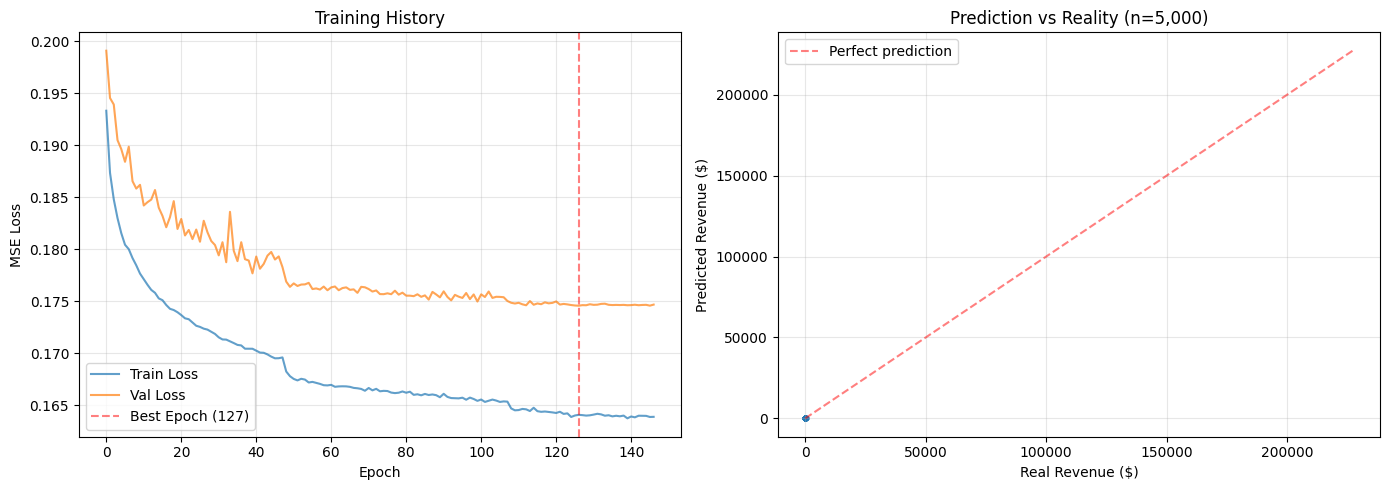


✓ Gráficas generadas


In [13]:
# Evaluar en validación
from time import time
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    start_time = time()
    pred_log = model(X_val_tensor).cpu().numpy().flatten()
    end_time = time()

print(f"⚡ Tiempo de inferencia: {end_time - start_time:.4f} segundos")
print(f"   Velocidad: {len(X_val) / (end_time - start_time):,.0f} samples/sec")

pred = np.expm1(pred_log).clip(0, None)

# Métricas
msle = mean_squared_log_error(y_val, pred)
rmse = mean_squared_error(y_val, pred)# squared=False)

print("\n" + "=" * 60)
print("RESULTADOS EN VALIDACIÓN (RESNET)")
print("=" * 60)
print(f"MSLE: {msle:.6f}")
print(f"RMSE: ${rmse:.2f}")
print(f"Revenue promedio predicho: ${pred.mean():.2f}")
print(f"Revenue promedio real: ${y_val.mean():.2f}")
print(f"Revenue mediano predicho: ${np.median(pred):.2f}")
print(f"Revenue mediano real: ${np.median(y_val):.2f}")
print("=" * 60)

# Análisis de distribución para sparse data
print(f"\n📊 ANÁLISIS DE PREDICCIONES SPARSE:")
print(f"  % predicciones = 0: {(pred == 0).sum() / len(pred) * 100:.2f}%")
print(f"  % predicciones < $1: {(pred < 1).sum() / len(pred) * 100:.2f}%")
print(f"  % predicciones < $5: {(pred < 5).sum() / len(pred) * 100:.2f}%")
print(f"  Max predicción: ${pred.max():.2f}")
print(f"\n  % real = 0: {(y_val == 0).sum() / len(y_val) * 100:.2f}%")
print(f"  % real < $1: {(y_val < 1).sum() / len(y_val) * 100:.2f}%")
print(f"  % real < $5: {(y_val < 5).sum() / len(y_val) * 100:.2f}%")
print(f"  Max real: ${y_val.max():.2f}")

# Plot loss curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(train_losses, label='Train Loss', alpha=0.7)
ax1.plot(val_losses, label='Val Loss', alpha=0.7)
ax1.axvline(x=best_epoch-1, color='r', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch})')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE Loss')
ax1.set_title('Training History')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Scatter plot: pred vs real
sample_size = min(5000, len(pred))
indices = np.random.choice(len(pred), sample_size, replace=False)
ax2.scatter(y_val.iloc[indices], pred[indices], alpha=0.3, s=10)
ax2.plot([0, y_val.max()], [0, y_val.max()], 'r--', alpha=0.5, label='Perfect prediction')
ax2.set_xlabel('Real Revenue ($)')
ax2.set_ylabel('Predicted Revenue ($)')
ax2.set_title(f'Prediction vs Reality (n={sample_size:,})')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Gráficas generadas")

In [ ]:
"""# GRID SEARCH PARA OPTIMIZAR HIPERPARÁMETROS
from sklearn.model_selection import ParameterGrid
import time

print("=" * 60)
print("GRID SEARCH - OPTIMIZACIÓN DE HIPERPARÁMETROS")
print("=" * 60)

# Definir grid de parámetros
param_grid = {
    'learning_rate': [0.01, 0.03, 0.05],
    'num_leaves': [31, 63, 127],
    'max_depth': [-1, 10, 15],
    'min_data_in_leaf': [20, 50, 100],
    'feature_fraction': [0.7, 0.8, 0.9],
    'bagging_fraction': [0.7, 0.8, 0.9]
}

# Base params
base_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'bagging_freq': 5,
    'verbose': -1,
    'device': 'cpu'
}

# Preparar datasets
cat_features_valid = [col for col in cat_features if col in features]
train_ds = lgb.Dataset(X_train, label=y_train_log, categorical_feature=cat_features_valid)
val_ds = lgb.Dataset(X_val, label=y_val_log, reference=train_ds)

# Grid search
results = []
best_score = float('inf')
best_params = None

grid = list(ParameterGrid(param_grid))
print(f"\nTotal combinaciones a probar: {len(grid)}")
print("Probando combinaciones (esto puede tardar)...\n")

for i, params in enumerate(grid[:20], 1):  # Limitar a 20 combinaciones para no tardar mucho
    print(f"[{i}/20] Probando: lr={params['learning_rate']}, leaves={params['num_leaves']}, depth={params['max_depth']}")
    
    # Combinar params
    current_params = {**base_params, **params}
    
    # Entrenar
    start_time = time.time()
    model_temp = lgb.train(
        current_params,
        train_ds,
        num_boost_round=500,  # Reducido para grid search
        valid_sets=[val_ds],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )
    elapsed = time.time() - start_time
    
    # Evaluar
    pred_log = model_temp.predict(X_val)
    pred = np.expm1(pred_log).clip(0, None)
    msle = mean_squared_log_error(y_val, pred)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    
    # Guardar resultado
    results.append({
        **params,
        'msle': msle,
        'rmse': rmse,
        'best_iteration': model_temp.best_iteration,
        'time': elapsed
    })
    
    print(f"  ✓ MSLE: {msle:.6f} | RMSE: {rmse:.2f} | Iters: {model_temp.best_iteration} | Time: {elapsed:.1f}s")
    
    # Actualizar mejor
    if msle < best_score:
        best_score = msle
        best_params = params
        print(f"  🎯 NUEVO MEJOR SCORE!")
    
    print()

# Mostrar resultados
print("=" * 60)
print("RESULTADOS GRID SEARCH")
print("=" * 60)

results_df = pd.DataFrame(results).sort_values('msle')
print("\nTop 5 mejores combinaciones:")
print(results_df.head(10).to_string(index=False))

print("\n" + "=" * 60)
print("MEJORES PARÁMETROS ENCONTRADOS:")
print("=" * 60)
for key, value in best_params.items():
    print(f"  {key}: {value}")
print(f"\nMejor MSLE: {best_score:.6f}")
print("=" * 60)

# Entrenar modelo final con mejores params
print("\nEntrenando modelo final con mejores parámetros...")
final_params = {**base_params, **best_params}

model_final = lgb.train(
    final_params,
    train_ds,
    num_boost_round=2000,
    valid_sets=[train_ds, val_ds],
    callbacks=[lgb.early_stopping(stopping_rounds=100)]
)

print(f"✓ Modelo final entrenado ({model_final.best_iteration} iteraciones)")

# Evaluar modelo final
pred_log = model_final.predict(X_val)
pred = np.expm1(pred_log).clip(0, None)
msle_final = mean_squared_log_error(y_val, pred)
rmse_final = np.sqrt(mean_squared_error(y_val, pred))

print("\n" + "=" * 60)
print("RESULTADOS FINALES CON MEJORES PARÁMETROS")
print("=" * 60)
print(f"MSLE: {msle_final:.6f}")
print(f"RMSE: ${rmse_final:.2f}")
print(f"Revenue promedio predicho: ${pred.mean():.2f}")
print(f"Revenue promedio real: ${y_val.mean():.2f}")
print("=" * 60)

# Guardar modelo final
model = model_final"""

'# GRID SEARCH PARA OPTIMIZAR HIPERPARÁMETROS\nfrom sklearn.model_selection import ParameterGrid\nimport time\n\nprint("=" * 60)\nprint("GRID SEARCH - OPTIMIZACIÓN DE HIPERPARÁMETROS")\nprint("=" * 60)\n\n# Definir grid de parámetros\nparam_grid = {\n    \'learning_rate\': [0.01, 0.03, 0.05],\n    \'num_leaves\': [31, 63, 127],\n    \'max_depth\': [-1, 10, 15],\n    \'min_data_in_leaf\': [20, 50, 100],\n    \'feature_fraction\': [0.7, 0.8, 0.9],\n    \'bagging_fraction\': [0.7, 0.8, 0.9]\n}\n\n# Base params\nbase_params = {\n    \'objective\': \'regression\',\n    \'metric\': \'rmse\',\n    \'bagging_freq\': 5,\n    \'verbose\': -1,\n    \'device\': \'cpu\'\n}\n\n# Preparar datasets\ncat_features_valid = [col for col in cat_features if col in features]\ntrain_ds = lgb.Dataset(X_train, label=y_train_log, categorical_feature=cat_features_valid)\nval_ds = lgb.Dataset(X_val, label=y_val_log, reference=train_ds)\n\n# Grid search\nresults = []\nbest_score = float(\'inf\')\nbest_params = None

NameError: name 'lgb' is not defined

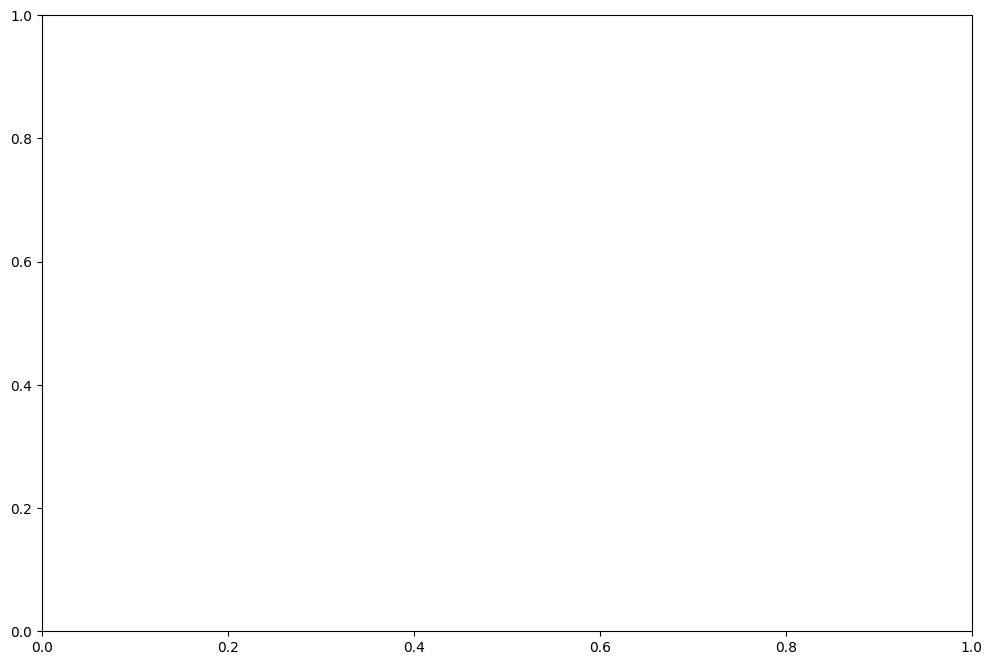

In [14]:
# Feature importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
lgb.plot_importance(model, max_num_features=30, ax=ax, title='Top 30 Features - Modelo Optimizado')
plt.tight_layout()
plt.show()

In [15]:
import time

TEST_PATH = "/home/stargix/Desktop/hackathons/datathon/test/test"
SUBMISSION_PATH = "/home/stargix/Desktop/hackathons/datathon/submission_neural_net.csv"

print("=" * 60)
print("GENERANDO PREDICCIONES EN TEST (GUARDADO INCREMENTAL)")
print("=" * 60)

# Preparar archivo CSV (escribir header)
import csv
with open(SUBMISSION_PATH, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['row_id', 'iap_revenue_d7'])

# Repartir parquet
test_meta = dd.read_parquet(TEST_PATH, engine="pyarrow", index=False).head(0)
available_cols = [c for c in ["row_id"] + features if c in test_meta.columns]

dd_test = dd.read_parquet(
    TEST_PATH,
    engine="pyarrow",
    columns=available_cols,
    blocksize="128MB"
)
dd_test = dd_test.repartition(npartitions=384)
delayed_parts = dd_test.to_delayed()
print(f"Chunks repartidos: {len(delayed_parts)}\n")

# Preparar ayudas vectorizadas
columns_to_sum = [
    "iap_revenue_usd_bundle", "num_buys_bundle", "rwd_prank",
    "whale_users_bundle_num_buys_prank", "whale_users_bundle_revenue_prank"
]
le_maps = {
    col: {cls: idx for idx, cls in enumerate(enc.classes_)}
    for col, enc in label_encoders.items()
}

def sum_list_series(series: pd.Series) -> pd.Series:
    return series.apply(
        lambda x: sum(item[1] for item in x if isinstance(item, tuple) and len(item) > 1)
        if isinstance(x, list) else 0
    )

model.eval()
total_rows = 0

for i, delayed_part in enumerate(delayed_parts, 1):
    t0 = time.perf_counter()
    part_df = delayed_part.compute()
    row_ids = part_df["row_id"].values

    X_part = part_df.reindex(columns=features, fill_value=0)

    for col in columns_to_sum:
        if col in X_part.columns:
            X_part[col] = sum_list_series(X_part[col])

    numeric_cols = [col for col in numeric_features if col in X_part.columns]
    if numeric_cols:
        X_part[numeric_cols] = X_part[numeric_cols].apply(pd.to_numeric, errors="coerce")
        X_part[numeric_cols] = X_part[numeric_cols].fillna(0)

    for col in cat_features:
        if col in X_part.columns:
            mapped = (
                X_part[col].astype(str)
                .map(le_maps[col])
                .fillna(-1)
                .astype("int32")
            )
            X_part[col] = mapped

    # Escalar
    X_part[numeric_features] = scaler.transform(X_part[numeric_features])
    
    # Predicción
    X_part_tensor = torch.FloatTensor(X_part.values).to(device)
    with torch.no_grad():
        pred_log = model(X_part_tensor).cpu().numpy().flatten()
    
    pred = np.expm1(pred_log).clip(0, None)

    # 🔥 GUARDAR INMEDIATAMENTE (append mode)
    chunk_df = pd.DataFrame({"row_id": row_ids, "iap_revenue_d7": pred})
    chunk_df.to_csv(SUBMISSION_PATH, mode='a', header=False, index=False)
    
    total_rows += len(row_ids)
    print(f"[{i}/{len(delayed_parts)}] {len(row_ids):,} filas | Total: {total_rows:,} | {time.perf_counter() - t0:.1f}s")
    
    del part_df, X_part, X_part_tensor, pred_log, pred, row_ids, chunk_df
    gc.collect()

print("\n" + "=" * 60)
print("✓ SUBMISSION GUARDADO INCREMENTALMENTE")
print("=" * 60)
print(f"Total filas: {total_rows:,}")
print(f"Archivo: {SUBMISSION_PATH}")
print("=" * 60)

# Verificar archivo final
submission = pd.read_csv(SUBMISSION_PATH)
print(f"\n✓ Verificación:")
print(f"  Filas: {len(submission):,}")
print(f"  Row IDs únicos: {submission['row_id'].nunique():,}")
print(f"  Duplicados: {submission['row_id'].duplicated().sum()}")
print(f"  NaNs: {submission['iap_revenue_d7'].isna().sum()}")
print(f"\nEstadísticas:")
print(submission['iap_revenue_d7'].describe())
submission.head(10)

GENERANDO PREDICCIONES EN TEST (GUARDADO INCREMENTAL)
Chunks repartidos: 384

Chunks repartidos: 384

[1/384] 29,611 filas | Total: 29,611 | 1.6s
[1/384] 29,611 filas | Total: 29,611 | 1.6s
[2/384] 29,611 filas | Total: 59,222 | 0.7s
[2/384] 29,611 filas | Total: 59,222 | 0.7s
[3/384] 29,612 filas | Total: 88,834 | 0.7s
[3/384] 29,612 filas | Total: 88,834 | 0.7s
[4/384] 29,611 filas | Total: 118,445 | 0.8s
[4/384] 29,611 filas | Total: 118,445 | 0.8s
[5/384] 29,612 filas | Total: 148,057 | 0.8s
[5/384] 29,612 filas | Total: 148,057 | 0.8s
[6/384] 29,611 filas | Total: 177,668 | 0.7s
[6/384] 29,611 filas | Total: 177,668 | 0.7s
[7/384] 29,611 filas | Total: 207,279 | 0.7s
[7/384] 29,611 filas | Total: 207,279 | 0.7s
[8/384] 29,612 filas | Total: 236,891 | 0.7s
[8/384] 29,612 filas | Total: 236,891 | 0.7s
[9/384] 29,611 filas | Total: 266,502 | 0.7s
[9/384] 29,611 filas | Total: 266,502 | 0.7s
[10/384] 29,612 filas | Total: 296,114 | 0.7s
[10/384] 29,612 filas | Total: 296,114 | 0.7s
[1

,row_id,iap_revenue_d7
0,e2f514a9-d922-4a17-bf94-f228bf4cd82f,0.003148
1,4bfc70d3-d619-410a-9683-4cd759f30f32,0.000705
2,ad433b66-b41e-4157-a6fd-24cd30701f6a,0.000339
3,5ed964d6-ddce-42e8-9fad-276eb7f64c2f,0.014785
4,81b73a45-c395-4d08-a4a3-513873440db3,0.000000
5,22c09d3c-037d-4733-be84-764b0beea8ef,0.076840
6,c991d87f-acee-40f5-9159-c2b9edd3c3ed,0.025200
7,2ab1e530-3dd4-4a36-a33a-d9fe1b934b60,0.000179
8,21fcdadc-5c27-4e31-8edf-1d84f93517ef,0.001729
9,8131e176-c2fe-41b1-99da-771096ce48f1,0.000000


In [ ]:
submission_path = "/home/stargix/Desktop/hackathons/datathon/submission_neural_net.csv"
submission.to_csv(submission_path, index=False)